In [28]:
import random
import numpy as np
from sklearn.datasets import fetch_openml

from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib notebook

In [29]:
X_raw, Y_raw = fetch_openml('mnist_784', version=1, return_X_y=True)

In [30]:
def onehot(ind, rangeMax = 9, rangeMin = 0):
    res = np.zeros(rangeMax - rangeMin + 1)
    res[ind - rangeMin] = 1
    return res

X = X_raw / 255.0
Y = np.array([onehot(ind) for ind in Y_raw.astype(int)])

data_set = [(x.reshape(784, 1), y.reshape(10, 1)) for (x, y) in zip(X, Y)]

In [31]:
class LinearLayer:
    def __init__(self, inpSize, outSize):
        self.inpSize = inpSize
        self.outSize = outSize
        self.W = 0.125*np.random.randn(outSize, inpSize)
        self.b = 0.125*np.random.randn(outSize, 1)
        
    def forward(self, inp):
        self.last_inp = inp
        return self.W @ inp + self.b
    
    def backward(self, correction, grad_norm = None):
        self.last_correction = correction
        return self.W.T @ correction
    
    def update(self, rate):
        self.W += rate * self.last_correction @ self.last_inp.T
        self.b += rate * self.last_correction
                
class SigmoidLayer:
    def sigmoid(self, x):
        return 1.0 / (1.0 + np.exp(-x))
    
    def sigmoid_derivative(self, x):
        return self.sigmoid(x) * (1.0 - self.sigmoid(x))
        
    def forward(self, inp):
        self.last_inp = inp
        return self.sigmoid(inp)
    
    def backward(self, correction, grad_norm = None):
        return self.sigmoid_derivative(self.last_inp)*correction
    
    def update(self, rate):
        pass

In [32]:
class NNetwork:
    def __init__(self, layers = None):
        if layers is None:
            self.layers = []
        else:
            self.layers = layers

    def add_layer(self, layer):
        self.layers += [layer]
        
    def add_layers(self, layers):
        self.layers += layers

    def forward(self, value):
        for layer in self.layers:
            value = layer.forward(value)
        return value

    def update(self, x, y, rate):
        correction = (y - self.forward(x))
        for i in range(1, len(self.layers) + 1):
            layer = self.layers[-i]
            correction = layer.backward(correction)
            layer.update(rate)
            
    def __call__(self, value):
        return self.forward(value)

In [33]:
def printAccuracy(model, test_data):
    correct = sum(np.argmax(model(x)) == np.argmax(y) for (x, y) in test_data)
    print(f'{correct} out of {len(test_data)} correct, accuracy = {correct / len(test_data)}')
    
def training(model, training_data, test_data = None, batch_size = None, epochs = 10, epochs_per_test = 1, rate=0.5):
    if batch_size is None:
        batch_size = len(training_data)
        
    for j in range(epochs):
        batch = random.sample(training_data, batch_size)
        error_sum = 0.0
        for (x, y) in batch:
            y_pred = model(x)
            error_sum += ((y - y_pred).T @ (y - y_pred))[0,0]
            model.update(x, y, rate)
            

        if (j + 1) % epochs_per_test == 0:
            if test_data:
                print (f'error_avg = {error_sum / (batch_size * epochs_per_test)}')
                error_sum = 0.0
                printAccuracy(model, test_data)
                

In [34]:
def getImageMatrices(model):
    W = []
    for layer in model.layers[-2::-2]:
        W += [np.eye(layer.W.shape[0])]
        for i in range(len(W)):
            W[i] = W[i] @ layer.W
    return W

def animatedTraining(model, training_data, test_data = None, batch_size = None, epochs = 50,
                     rate = 0.5, rate_decay = 0.0125):
    if batch_size is None:
        batch_size = len(training_data)

    figs = None
    ax = None

    for epoch in range(epochs):
        training(model, training_data = training_data, test_data = test_data if epoch % 10 == 9 else None,
                  batch_size = batch_size, epochs = 1, rate = rate)

        imageWs = getImageMatrices(model)
        if figs is None:
            figs = []
            axs = [[] for _ in range(len(imageWs))]
                        
            for j in range(len(imageWs) -1, -1, -1):
                iW = imageWs[j]
                figs = [plt.figure(figsize=(2.0*5, (2.0+0.5)*((iW.shape[0] + 4)//5)))] + figs
                
                for i in range(iW.shape[0]):
                    axs[j].append(figs[0].add_subplot((iW.shape[0] + 4)//5, 5, i + 1))
                    axs[j][-1].set_title(str(i))
                    axs[j][-1].set_xticks([])
                    axs[j][-1].set_yticks([])
                        
        for j in range(len(imageWs)):
            iW = imageWs[j]
            for i in range(iW.shape[0]):
                axs[j][i].imshow(iW[i,:].reshape(28, 28), cmap=plt.cm.get_cmap('seismic'))
            figs[j].canvas.draw()            

        rate *= (1.0 - rate_decay)

<IPython.core.display.Javascript object>


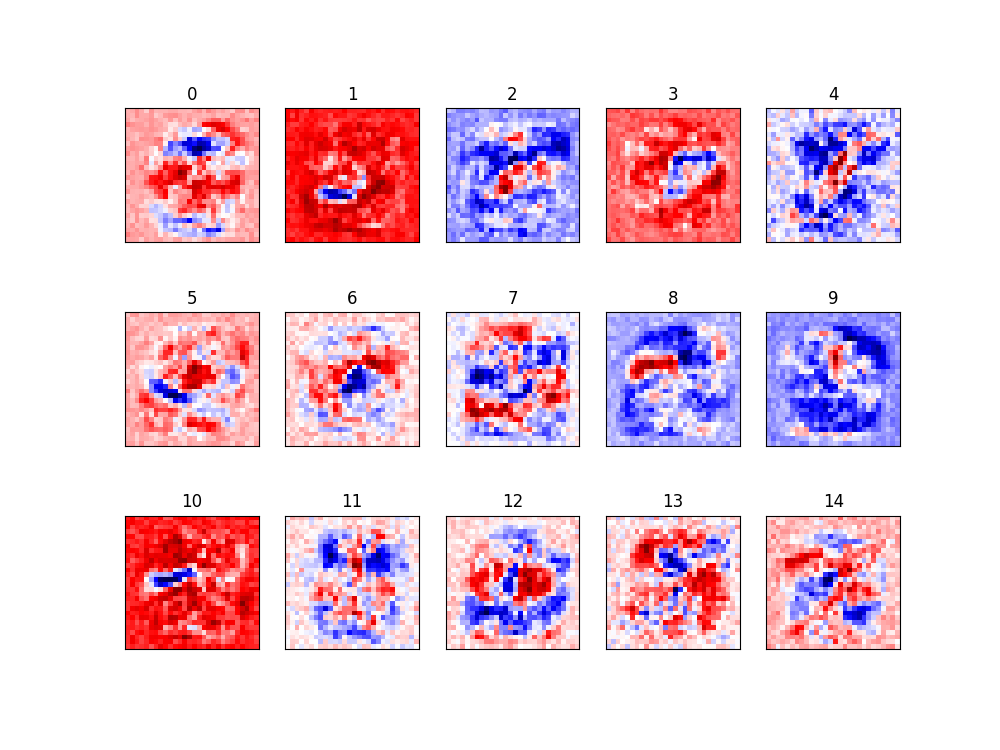

<IPython.core.display.Javascript object>


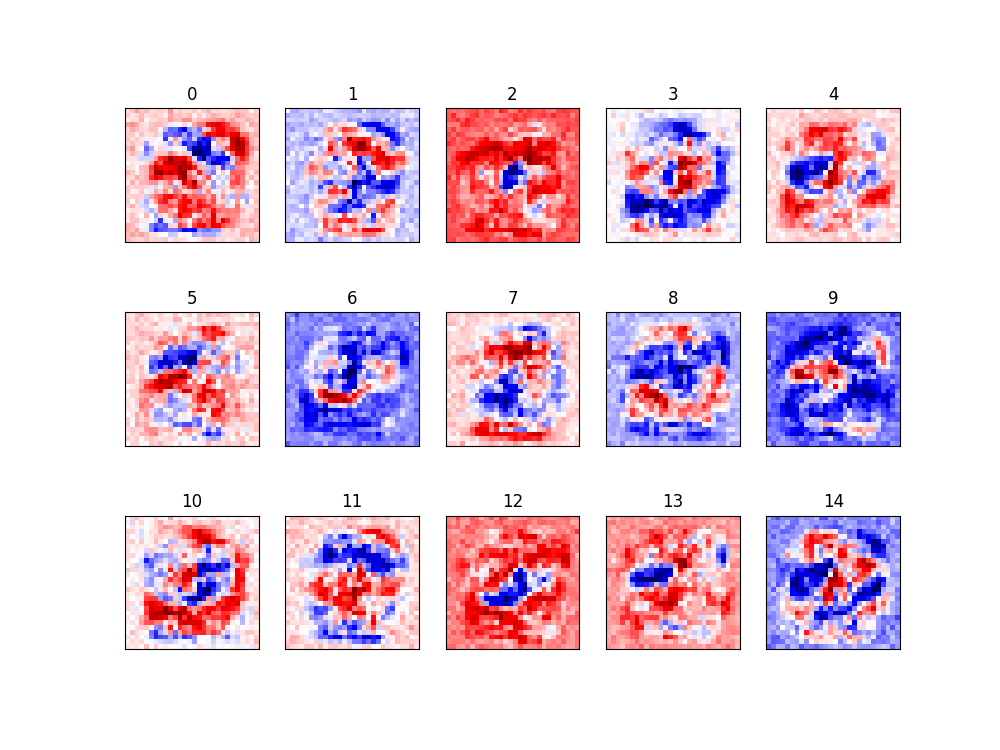

<IPython.core.display.Javascript object>


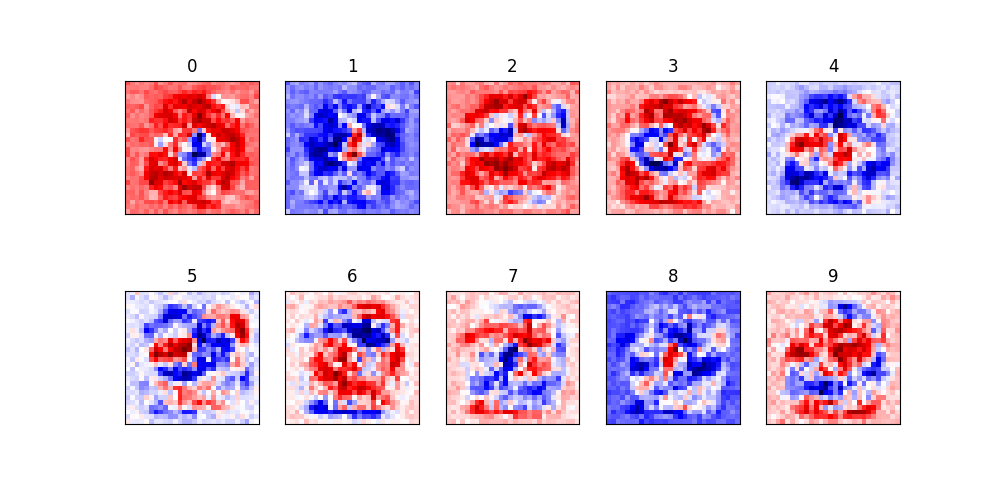

error_avg = 0.14881988725402107
4365 out of 5000 correct, accuracy = 0.873
error_avg = 0.12538005479572056
4531 out of 5000 correct, accuracy = 0.9062
error_avg = 0.10364079689980463
4572 out of 5000 correct, accuracy = 0.9144
error_avg = 0.10687517088158918
4540 out of 5000 correct, accuracy = 0.908
error_avg = 0.08703892832971794
4606 out of 5000 correct, accuracy = 0.9212
error_avg = 0.08336185059847671
4606 out of 5000 correct, accuracy = 0.9212
error_avg = 0.07793971773586389
4633 out of 5000 correct, accuracy = 0.9266
error_avg = 0.07439178817022254
4639 out of 5000 correct, accuracy = 0.9278
error_avg = 0.07527145206505406
4629 out of 5000 correct, accuracy = 0.9258
error_avg = 0.06821360756625669
4629 out of 5000 correct, accuracy = 0.9258


In [35]:
m15x2 = NNetwork([LinearLayer(28*28, 15), SigmoidLayer(),
                  LinearLayer(15, 15), SigmoidLayer(),
                  LinearLayer(15, 10), SigmoidLayer(),
                 ])

animatedTraining(m15x2, data_set[:20000], data_set[20000:25000], batch_size = 2500, epochs = 100)